## ALright, the goal is to get some sort of linearregression going, then a polynomial, I first need to understand what it is im doing and be ab
Here is the attempt, 

In [2]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

In [3]:
# Loading dataset
df = pd.read_csv('./canada_rent.csv')
df

,rentfaster_id,city,province,address,latitude,longitude,lease_term,type,price,beds,baths,sq_feet,link,furnishing,availability_date,smoking,cats,dogs
0,468622,Airdrie,Alberta,69 Gateway Dr NE,51.305962,-114.012515,Long Term,Townhouse,2495.0,2 Beds,2.5,1403,/ab/airdrie/rentals/townhouse/2-bedrooms/pet-f...,Unfurnished,Immediate,Non-Smoking,True,True
1,468622,Airdrie,Alberta,69 Gateway Dr NE,51.305962,-114.012515,Long Term,Townhouse,2695.0,3 Beds,2.5,1496,/ab/airdrie/rentals/townhouse/2-bedrooms/pet-f...,Unfurnished,Immediate,Non-Smoking,True,True
2,468622,Airdrie,Alberta,69 Gateway Dr NE,51.305962,-114.012515,Long Term,Townhouse,2295.0,2 Beds,2.5,1180,/ab/airdrie/rentals/townhouse/2-bedrooms/pet-f...,Unfurnished,Immediate,Non-Smoking,True,True
3,468622,Airdrie,Alberta,69 Gateway Dr NE,51.305962,-114.012515,Long Term,Townhouse,2095.0,2 Beds,2.5,1403,/ab/airdrie/rentals/townhouse/2-bedrooms/pet-f...,Unfurnished,November 18,Non-Smoking,True,True
4,468622,Airdrie,Alberta,69 Gateway Dr NE,51.305962,-114.012515,Long Term,Townhouse,2495.0,2 Beds,2.5,1403,/ab/airdrie/rentals/townhouse/2-bedrooms/pet-f...,Unfurnished,Immediate,Non-Smoking,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25766,334285,Yorkton,Saskatchewan,18 Allanbrooke Dr,51.203024,-102.484782,Long Term,Apartment,920.0,Studio,1,400,/sk/yorkton/rentals/apartment/3-bedrooms/pet-f...,Unfurnished,Immediate,Non-Smoking,True,True
25767,334285,Yorkton,Saskatchewan,18 Allanbrooke Dr,51.203024,-102.484782,Long Term,Apartment,1450.0,3 Beds,1,810,/sk/yorkton/rentals/apartment/3-bedrooms/pet-f...,Unfurnished,Immediate,Non-Smoking,True,True
25768,334284,Yorkton,Saskatchewan,363 Northview Rd,51.202667,-102.485765,Long Term,Apartment,1125.0,1 Bed,1,520,/sk/yorkton/rentals/apartment/1-bedroom/pet-fr...,Unfurnished,Immediate,Non-Smoking,True,True
25769,334284,Yorkton,Saskatchewan,363 Northview Rd,51.202667,-102.485765,Long Term,Apartment,920.0,Studio,1,400,/sk/yorkton/rentals/apartment/1-bedroom/pet-fr...,Unfurnished,Immediate,Non-Smoking,True,True


In [4]:
# EDA stuff: Display summary statistics
print(df.head())
print(df.info())
print(df.describe())

   rentfaster_id     city province           address   latitude   longitude  \
0         468622  Airdrie  Alberta  69 Gateway Dr NE  51.305962 -114.012515   
1         468622  Airdrie  Alberta  69 Gateway Dr NE  51.305962 -114.012515   
2         468622  Airdrie  Alberta  69 Gateway Dr NE  51.305962 -114.012515   
3         468622  Airdrie  Alberta  69 Gateway Dr NE  51.305962 -114.012515   
4         468622  Airdrie  Alberta  69 Gateway Dr NE  51.305962 -114.012515   

  lease_term       type   price    beds baths sq_feet  \
0  Long Term  Townhouse  2495.0  2 Beds   2.5    1403   
1  Long Term  Townhouse  2695.0  3 Beds   2.5    1496   
2  Long Term  Townhouse  2295.0  2 Beds   2.5    1180   
3  Long Term  Townhouse  2095.0  2 Beds   2.5    1403   
4  Long Term  Townhouse  2495.0  2 Beds   2.5    1403   

                                                link   furnishing  \
0  /ab/airdrie/rentals/townhouse/2-bedrooms/pet-f...  Unfurnished   
1  /ab/airdrie/rentals/townhouse/2-bedrooms/

In [5]:
# let's find our NAN values
print(df.isna().sum()) # lets see what's NAN and get rid of annoyances.

rentfaster_id           0
city                    0
province                0
address               125
latitude                0
longitude               0
lease_term             46
type                    0
price                   0
beds                  132
baths                 134
sq_feet              4112
link                    0
furnishing              0
availability_date      12
smoking              2702
cats                  173
dogs                  173
dtype: int64


In [6]:
# I have 125 nan values for addresses, but they may have city, province I can disregard since it is implied. it's not a large ammount that's contributable (125 out of 25k) but is good to be curious how to save it:

mask_address = pd.isnull(df['address']) # fetching those with nan values
df[mask_address]


,rentfaster_id,city,province,address,latitude,longitude,lease_term,type,price,beds,baths,sq_feet,link,furnishing,availability_date,smoking,cats,dogs
33,570898,Airdrie,Alberta,NaN,51.277740,-114.041061,Long Term,Basement,1700.0,2 Beds,1,757,/ab/airdrie/rentals/basement/2-bedrooms/non-sm...,Unfurnished,Immediate,Non-Smoking,False,False
35,564822,Airdrie,Alberta,NaN,51.291081,-114.051238,Long Term,Main Floor,2675.0,3 Beds,2.5,1575,/ab/airdrie/rentals/main-floor/3-bedrooms/non-...,Unfurnished,Immediate,Non-Smoking,False,False
36,569541,Airdrie,Alberta,NaN,51.257747,-113.991063,Long Term,Duplex,2700.0,3 Beds,2.5,1488,/ab/airdrie/rentals/duplex/3-bedrooms/non-smok...,Unfurnished,Immediate,Non-Smoking,False,False
42,571557,Airdrie,Alberta,NaN,51.258837,-114.025663,Long Term,Storage,600.0,NaN,NaN,NaN,/ab/airdrie/rentals/storage/non-smoking/571557,Unfurnished,Immediate,Non-Smoking,NaN,NaN
44,571493,Airdrie,Alberta,NaN,51.262392,-114.046187,Negotiable,Basement,1600.0,2 Beds,1,1000,/ab/airdrie/rentals/basement/2-bedrooms/non-sm...,Unfurnished,Immediate,Non-Smoking,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22389,430777,Toronto,Ontario,NaN,43.641753,-79.410356,Long Term,Condo Unit,2425.0,1 Bed,1,520,/on/toronto/rentals/condo/1-bedroom/pet-friend...,Unfurnished,June 15,Non-Smoking,True,True
22443,572399,Toronto,Ontario,NaN,43.787486,-79.338553,Long Term,Basement,2700.0,2 Beds,1,NaN,/on/toronto/rentals/basement/2-bedrooms/non-sm...,Negotiable,September 01,Non-Smoking,False,False
22444,572154,Toronto,Ontario,NaN,43.659655,-79.376019,Short Term,Condo Unit,2250.0,Studio,1,504,/on/toronto/rentals/condo/studio/short-term/57...,Furnished,September 01,Non-Smoking,False,False
22525,566632,Waterloo,Ontario,NaN,43.457737,-80.556674,Negotiable,Townhouse,900.0,1 Bed,1,NaN,/on/waterloo/rentals/townhouse/1-bedroom/furni...,Furnished,Immediate,Non-Smoking,False,False


In [7]:
# rows where address has NaN 
mask_address_nan = df['address'].isnull()

# Further filter to check if city does not have NaN values
mask_city_not_nan = ~df.loc[mask_address_nan, 'city'].isnull()

# Select the rows that match both conditions
rows_with_city = df.loc[mask_address_nan & mask_city_not_nan]
rows_with_city


,rentfaster_id,city,province,address,latitude,longitude,lease_term,type,price,beds,baths,sq_feet,link,furnishing,availability_date,smoking,cats,dogs
33,570898,Airdrie,Alberta,NaN,51.277740,-114.041061,Long Term,Basement,1700.0,2 Beds,1,757,/ab/airdrie/rentals/basement/2-bedrooms/non-sm...,Unfurnished,Immediate,Non-Smoking,False,False
35,564822,Airdrie,Alberta,NaN,51.291081,-114.051238,Long Term,Main Floor,2675.0,3 Beds,2.5,1575,/ab/airdrie/rentals/main-floor/3-bedrooms/non-...,Unfurnished,Immediate,Non-Smoking,False,False
36,569541,Airdrie,Alberta,NaN,51.257747,-113.991063,Long Term,Duplex,2700.0,3 Beds,2.5,1488,/ab/airdrie/rentals/duplex/3-bedrooms/non-smok...,Unfurnished,Immediate,Non-Smoking,False,False
42,571557,Airdrie,Alberta,NaN,51.258837,-114.025663,Long Term,Storage,600.0,NaN,NaN,NaN,/ab/airdrie/rentals/storage/non-smoking/571557,Unfurnished,Immediate,Non-Smoking,NaN,NaN
44,571493,Airdrie,Alberta,NaN,51.262392,-114.046187,Negotiable,Basement,1600.0,2 Beds,1,1000,/ab/airdrie/rentals/basement/2-bedrooms/non-sm...,Unfurnished,Immediate,Non-Smoking,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22389,430777,Toronto,Ontario,NaN,43.641753,-79.410356,Long Term,Condo Unit,2425.0,1 Bed,1,520,/on/toronto/rentals/condo/1-bedroom/pet-friend...,Unfurnished,June 15,Non-Smoking,True,True
22443,572399,Toronto,Ontario,NaN,43.787486,-79.338553,Long Term,Basement,2700.0,2 Beds,1,NaN,/on/toronto/rentals/basement/2-bedrooms/non-sm...,Negotiable,September 01,Non-Smoking,False,False
22444,572154,Toronto,Ontario,NaN,43.659655,-79.376019,Short Term,Condo Unit,2250.0,Studio,1,504,/on/toronto/rentals/condo/studio/short-term/57...,Furnished,September 01,Non-Smoking,False,False
22525,566632,Waterloo,Ontario,NaN,43.457737,-80.556674,Negotiable,Townhouse,900.0,1 Bed,1,NaN,/on/waterloo/rentals/townhouse/1-bedroom/furni...,Furnished,Immediate,Non-Smoking,False,False


In [8]:
# Aright they do have cities, lets change these address values to zero just so we keep them
rows_with_city['address'].fillna(0) 

# update df
df.update(rows_with_city)
rows_with_city

,rentfaster_id,city,province,address,latitude,longitude,lease_term,type,price,beds,baths,sq_feet,link,furnishing,availability_date,smoking,cats,dogs
33,570898,Airdrie,Alberta,NaN,51.277740,-114.041061,Long Term,Basement,1700.0,2 Beds,1,757,/ab/airdrie/rentals/basement/2-bedrooms/non-sm...,Unfurnished,Immediate,Non-Smoking,False,False
35,564822,Airdrie,Alberta,NaN,51.291081,-114.051238,Long Term,Main Floor,2675.0,3 Beds,2.5,1575,/ab/airdrie/rentals/main-floor/3-bedrooms/non-...,Unfurnished,Immediate,Non-Smoking,False,False
36,569541,Airdrie,Alberta,NaN,51.257747,-113.991063,Long Term,Duplex,2700.0,3 Beds,2.5,1488,/ab/airdrie/rentals/duplex/3-bedrooms/non-smok...,Unfurnished,Immediate,Non-Smoking,False,False
42,571557,Airdrie,Alberta,NaN,51.258837,-114.025663,Long Term,Storage,600.0,NaN,NaN,NaN,/ab/airdrie/rentals/storage/non-smoking/571557,Unfurnished,Immediate,Non-Smoking,NaN,NaN
44,571493,Airdrie,Alberta,NaN,51.262392,-114.046187,Negotiable,Basement,1600.0,2 Beds,1,1000,/ab/airdrie/rentals/basement/2-bedrooms/non-sm...,Unfurnished,Immediate,Non-Smoking,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22389,430777,Toronto,Ontario,NaN,43.641753,-79.410356,Long Term,Condo Unit,2425.0,1 Bed,1,520,/on/toronto/rentals/condo/1-bedroom/pet-friend...,Unfurnished,June 15,Non-Smoking,True,True
22443,572399,Toronto,Ontario,NaN,43.787486,-79.338553,Long Term,Basement,2700.0,2 Beds,1,NaN,/on/toronto/rentals/basement/2-bedrooms/non-sm...,Negotiable,September 01,Non-Smoking,False,False
22444,572154,Toronto,Ontario,NaN,43.659655,-79.376019,Short Term,Condo Unit,2250.0,Studio,1,504,/on/toronto/rentals/condo/studio/short-term/57...,Furnished,September 01,Non-Smoking,False,False
22525,566632,Waterloo,Ontario,NaN,43.457737,-80.556674,Negotiable,Townhouse,900.0,1 Bed,1,NaN,/on/waterloo/rentals/townhouse/1-bedroom/furni...,Furnished,Immediate,Non-Smoking,False,False


In [9]:
# super, it worked. 
print(df.isna().sum())

rentfaster_id           0
city                    0
province                0
address               125
latitude                0
longitude               0
lease_term             46
type                    0
price                   0
beds                  132
baths                 134
sq_feet              4112
link                    0
furnishing              0
availability_date      12
smoking              2702
cats                  173
dogs                  173
dtype: int64


In [10]:
# Rest I don't care for, drop em. 
df.dropna(inplace=True)
print(df.isna().sum())

rentfaster_id        0
city                 0
province             0
address              0
latitude             0
longitude            0
lease_term           0
type                 0
price                0
beds                 0
baths                0
sq_feet              0
link                 0
furnishing           0
availability_date    0
smoking              0
cats                 0
dogs                 0
dtype: int64


In [11]:
# Clean Furnishing column discrepency
df.loc[df['furnishing'] == 'Unfurnished, Negotiable', 'furnishing'] = 'Negotiable'

In [12]:
# Use relevant columns I think are necessary to predict prices. 
cols_to_use = ['city', 'lease_term', 'type', 'price', 'beds', 'baths', 'sq_feet', 'furnishing', 'smoking', 'cats', 'dogs']
df = df[cols_to_use]

In [13]:
# let's prep what to encode
columns_to_encode = ['city', 'lease_term', 'type', 'beds', 'furnishing', 'smoking', 'cats', 'dogs' ] 

one_hot_encoder = OneHotEncoder(sparse_output=False) # Initialize OneHotEncoder 
encoded_columns = one_hot_encoder.fit_transform(df[columns_to_encode])# commit to fit and transform specified columns,

# Remmeber that fit takes all the unique categories and transform commits those changes to numeric values

# Create a DataFrame of the encoded columns with appropriate column names
encoded_columns_df = pd.DataFrame(encoded_columns, columns=one_hot_encoder.get_feature_names_out(columns_to_encode))
encoded_columns_df.index = df.index # Ensure the index of new df matches the original df

# Drop the original columns and concatenate the encoded columns to the original DataFrame
df = pd.concat([df.drop(columns_to_encode, axis=1), encoded_columns_df], axis=1)

In [14]:
df

,price,baths,sq_feet,city_Abbotsford,city_Airdrie,city_Ajax,city_Aldersyde,city_Amherstview,city_Ancaster,city_Assiniboia,...,furnishing_Negotiable,furnishing_Unfurnished,smoking_Negotiable,smoking_Non-Smoking,smoking_Smoke Free Building,smoking_Smoking Allowed,cats_False,cats_True,dogs_False,dogs_True
0,2495.0,2.5,1403,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
1,2695.0,2.5,1496,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
2,2295.0,2.5,1180,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
3,2095.0,2.5,1403,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
4,2495.0,2.5,1403,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25766,920.0,1,400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
25767,1450.0,1,810,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
25768,1125.0,1,520,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
25769,920.0,1,400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0


Everything numeric? .. CHECK SQ_FEET STRINGS

Noticed there is a none value in baths, lets make that zero

In [16]:
df['baths'].unique()

array(['2.5', '1', '2', '1.5', '3.5', '4', '3', '5', 'none', '4.5', '7.5',
       '5.5', '6', '6.5', '0', '7'], dtype=object)

In [17]:
df['baths'] = df['baths'].replace({'none': 0})
df['baths'] = df['baths'].astype(float)

Sq_feet had weird values, we can do the following to extract numerics.

In [19]:
df['sq_feet'] = pd.to_numeric(df['sq_feet'].str.extract('(\d+)', expand=False), errors='coerce')
df['sq_feet'] = df['sq_feet'].fillna(0)
# EDIT ALL WEIRD cells with string elements in them

In [20]:
# Split data into features and target variable
X = df.drop(columns=['price'])
y = df['price']

1.1 Train-Test Split Steps
Typically, the steps involved in a basic train-test split involve:

Clean and prepare data as necessary for X and y 
Split data to train/test for both X and y
Fit/train scaler on X_train (by applying the fit_transform method)
Scale X_test data (by applying the transform method only)
Load model from scikit learn class and then create instance of model
Fit/train model on scaled/transformed X_train data
Evaluate model on X_test data (by creating predictions and comparing to original y_test)
Adjust parameters as necessary and repeat steps 6 and 7
We've performed these steps many times now, so let's jump straight into Train-Validate-Test.

From lecture: 

70% of data for training, set aside other 30% for validation and testing
X_train, X_OTHER, y_train, y_OTHER = train_test_split(X, y, test_size=0.3, random_state=1)

Remaining 30% is divided equally into validation (15%) and test (15%) data
X_val, X_test, y_val, y_test = train_test_split(X_OTHER, y_OTHER, test_size=0.5, random_state=1)

1.2 Train-Validation-Test Split Steps
This test set in this method is also referred to as a "hold-out" set, since we only use this set of data for reporting and evaluation purposes, and we DON'T adjust parameters after this final step.

In [23]:
# Split data into training and testing sets
X_train, X_other, y_train, y_other = train_test_split(X, y, test_size=0.3, random_state=2) # hold out

# Further split the temp set into validation and test sets
X_valid, X_test, y_valid, y_test = train_test_split(X_other, y_other, test_size=0.5, random_state=2)

In [24]:
imputer = SimpleImputer(strategy='mean')

X_train = imputer.fit_transform(X_train)
X_valid = imputer.transform(X_valid)
X_test = imputer.transform(X_test)

# Standardize numerical features so its easier for algorithem to compute.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

## Now that we have base model defined, lets start defining some linear, L1, and L2. just to get some sort of visual going. 

I am choose CV approach because I understand the importance to divide training data and train on each one, could strain calculations but it will certainly help with accuracy.

In [27]:
# Define models with cross-validation for Ridge and Lasso
alphas = [0.1, 1, 10, 100] # log10 incriments
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': RidgeCV(alphas=alphas, cv=5),
    'Lasso Regression': LassoCV(alphas=alphas, max_iter=10000, cv=5)
}

best_model = None
best_score = float('-inf')

for name, model in models.items():
    # Train model
    model.fit(X_train, y_train)
    
    # Evaluate on validation set
    y_valid_pred = model.predict(X_valid)
    valid_rmse = np.sqrt(mean_squared_error(y_valid, y_valid_pred))
    valid_r2 = r2_score(y_valid, y_valid_pred)
    
    print(f"{name} - Validation RMSE: {valid_rmse}, R^2: {valid_r2}")
    
    # Update best model based on validation score
    if valid_r2 > best_score:
        best_score = valid_r2
        best_model = model

# Final evaluation on test set
y_test_pred = best_model.predict(X_test)
print(f"Final Model - Test RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred))}, R^2: {r2_score(y_test, y_test_pred)}")

# Save the final model and other details in your repository

Linear Regression - Validation RMSE: 102541809640937.33, R^2: -1.122591937719041e+22
Ridge Regression - Validation RMSE: 507.1732978251009, R^2: 0.7253796448882466
Lasso Regression - Validation RMSE: 506.8334207316712, R^2: 0.7257475897071441
Final Model - Test RMSE: 531.6969564151743, R^2: 0.6398612170917244


Linear Regression is clearly underperforming. Makes sense I would think,
Ridge and Lasso Regression both show promising results, should continue with those. 

Remember that both RidgeCV and LassoCV are based on linear regression and include the assumption of homoscedasticity, 
Homoscedasticity is the statistical assumption that variance of the error term is constant across all levels of the independent variables

Check homostedacitiy, lets make subplots to get some visuals asto what we're working with. 

C:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


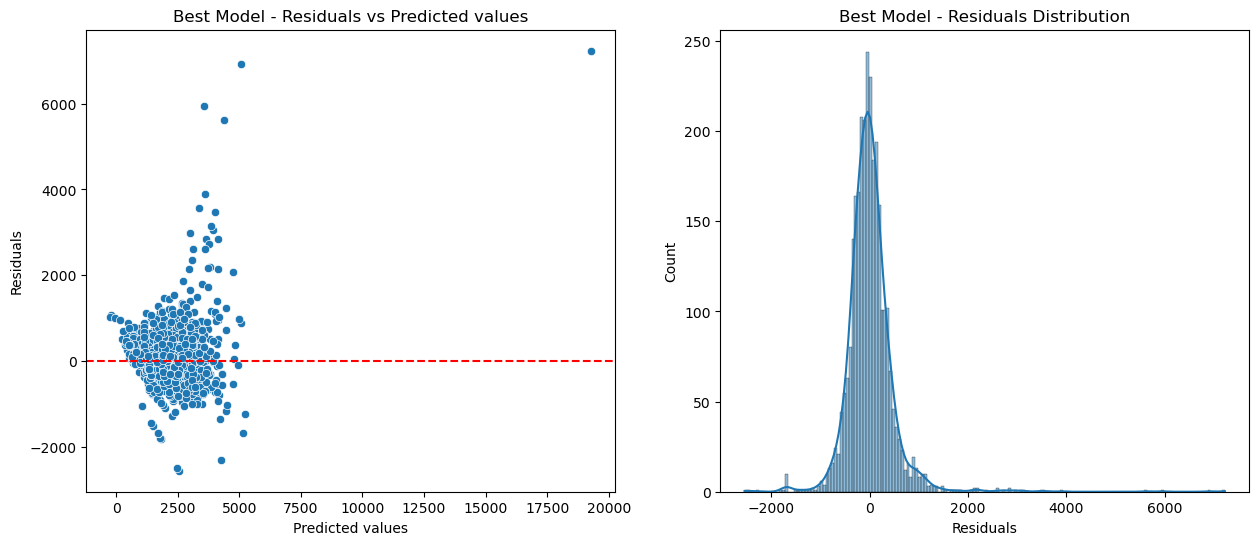

In [30]:
def plot_residuals(y_true, y_pred, model_name): # lets define plot resideuals to take in our model and predict.
    residuals = y_true - y_pred 
    plt.figure(figsize=(15, 6))
    
    # Residuals vs Predicted values
    plt.subplot(1, 2, 1)
    sns.scatterplot(x=y_pred, y=residuals)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Predicted values')
    plt.ylabel('Residuals')
    plt.title(f'{model_name} - Residuals vs Predicted values')

    # Histogram residuals
    plt.subplot(1, 2, 2)
    sns.histplot(residuals, kde=True)
    plt.xlabel('Residuals')
    plt.title(f'{model_name} - Residuals Distribution')
    plt.show()

# Plot residuals
y_valid_pred_best = best_model.predict(X_valid)
plot_residuals(y_valid, y_valid_pred_best, 'Best Model')

 Suggests that residuals do not have constant variance and exhibit heteroscedasticity, this is good
 Graph on right shows we have many values near zero which is what we want, if ths was a properbell curve it would be worrisome.

<Figure size 2100x600 with 0 Axes>

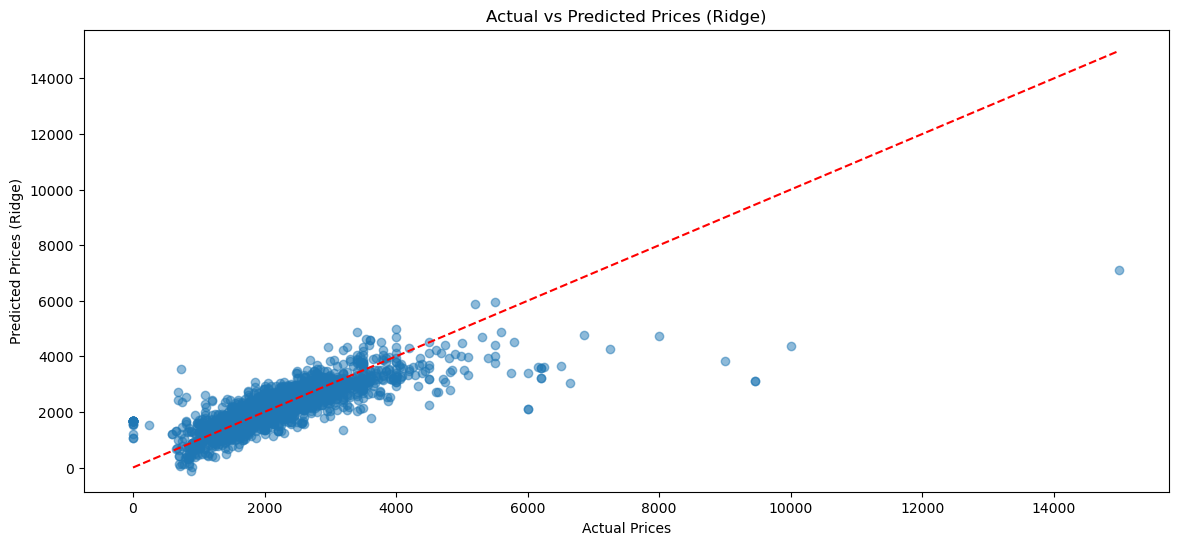

In [32]:
# Lets plot a RidgeCV
plt.figure(figsize=(21, 6))

# Ridge Regression
plt.figure(figsize=(14, 6))
best_ridge_model = RidgeCV() 
best_ridge_model.fit(X_train, y_train)
y_pred_ridge = best_ridge_model.predict(X_test)
plt.scatter(y_test, y_pred_ridge, alpha=0.5)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices (Ridge)')
plt.title('Actual vs Predicted Prices (Ridge)')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')  # Add a line for reference

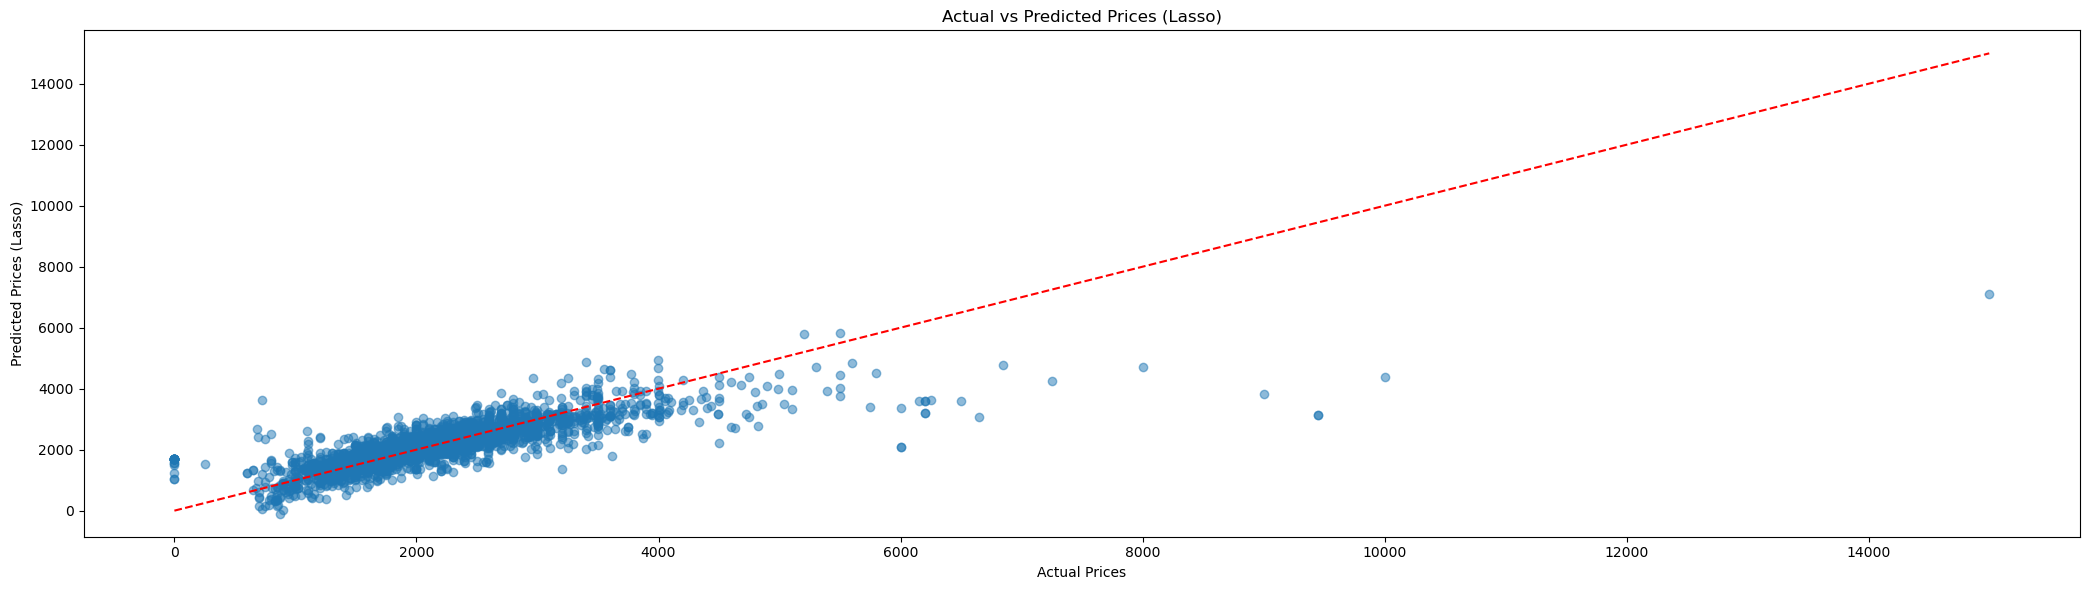

In [33]:
# Now the LassoCV
plt.figure(figsize=(21, 6))

# LassoCV Regression
lasso_model = LassoCV(max_iter=10000)
lasso_model.fit(X_train, y_train)
y_pred_lasso = lasso_model.predict(X_test)
plt.scatter(y_test, y_pred_lasso, alpha=0.5)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices (Lasso)')
plt.title('Actual vs Predicted Prices (Lasso)')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')  # Add a line for reference

plt.tight_layout()
plt.show()

Well alright, we certainly gotta try polymonial because it's clear to me it should be steeping down towards the right. 

In [ ]:
lasso_model = LassoCV(max_iter=10000)
lasso_model.fit(X_train / 1.5, y_train / 1.5)
y_pred_lasso = lasso_model.predict(X_test)

# Plot the scatter plot of actual vs predicted values
plt.figure(figsize=(21, 6))
plt.scatter(y_test, y_pred_lasso, alpha=0.5)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices (Lasso)')
plt.title('Actual vs Predicted Prices (Lasso)')

# Add a reference line
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')

# Fit a polynomial of degree 2 (quadratic) as an example
degree = 2
coeffs = np.polyfit(y_test, y_pred_lasso, degree) 
poly = np.poly1d(coeffs)
x_range = np.linspace(min(y_test), max(y_test), 100)
y_poly = poly(x_range)

# Plot the polynomial fit
plt.plot(x_range, y_poly, 'g-', label=f'Poly fit (degree {degree})')

plt.legend()
plt.tight_layout()
plt.show()

Degree 2 does do a good job tracing, However I do need to explore higher degrees 

In [ ]:
from sklearn.pipeline import Pipeline
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

# polynomial degrees to test
degrees = range(1, 5)

# lists to store results
train_rmses = []
test_rmses = []

for degree in degrees:
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    
    # Create a pipeline with scaling and regression
    model = Pipeline([
        ('poly', poly),
        ('scaler', StandardScaler()),
        ('regressor', LinearRegression())
    ])
    
    # Fit the model on the training data
    model.fit(X_train, y_train)
    
    # Predict on training and calculate RMSE
    y_train_pred = model.predict(X_train)
    train_rmse = np.sqrt(np.mean((y_train - y_train_pred) ** 2))
    train_rmses.append(train_rmse)
    
    # Predict on testing and calculate RMSE
    y_test_pred = model.predict(X_test)
    test_rmse = np.sqrt(np.mean((y_test - y_test_pred) ** 2))
    test_rmses.append(test_rmse)

# results df output
results_df = pd.DataFrame({
    'Degree': degrees,
    'Train RMSE': train_rmses,
    'Test RMSE': test_rmses
})

results_df


## CURRENT THOUGHTS,

- I need to review key terms, I'm certain I have been repeating myself feel and have redefined over and over too many times, can be causing headaches all around.
- My Dataframe just has too many categories to do a polynomial, need to find a better way to narrow and still be effective. Certain statsmodels can help me there. 


<!-- REMEMBER I STILL NEED TO FIND ANOTHER MODEL TO TRY THIS ON,  -->


1.2 Train-Validation-Test Split Steps
This test set in this method is also referred to as a "hold-out" set, since we only use this set of data for reporting and evaluation purposes, and we DON'T adjust parameters after this final step.

Typically, the steps involved in a train-validate-test split involve:

Clean and prepare data as necessary for X and y
Split data to train/validation/test for both X and y (typicall a 70/15/15 percentage for each)
Fit/train scaler on X_train (by applying the fit_transform method)
Scale X_val and X_test data (by applying the transform method only)
Load model from scikit learn class and then create instance of model
Fit/train model on scaled/transformed X_train data
Evaluate model on X_val data (by creating predictions and comparing to y_val)
Adjust parameters as necessary and repeat steps 6 and 7
Get final metrics on test set (cannot adjust parameters after this step)
Retrain model on entire X, y data set (optional, but cannot get metrics from this step since the model has already seen all this data)
To achieve a train-validation-test split with scikit-learn, we can perform the standard train-test split using the train_test_split() method twice. Once to split off the training data from the validation and test data, and a second time to split the validation and test data.

Your goal is to explore multiple regression models, in order to find a model that predicts the rental price most accurately.

Here are the criteria your project needs to meet:

Project Submission
You will upload your completed project in a PUBLIC Github repository in your account.
Your repository MUST include:
a README.md page that includes a description and summary of your analysis.
The completed .ipynb notebook with your analysis.
Your notebook has to be organized and clean. Break down your steps, and follow coding best practices.
Notebook Criteria
Your analysis needs to include an EDA section.
Keep an eye on important features and potential issues.
Use visualization to identify trends/patterns.
Clean and prepare your data as necessary.
Use Feature-Engineering where necessary. Always include an explanation of why you did or did not perform a step.
You must compare at least 3 regression models.
You must choose a validation scheme (simple or cross-validation).
Explain which features you have chosen for your final model and why.
You must try your final model by using it to make new predictions on input that you provide.
Good luck!

In [ ]:
Incomplete, 